In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as plx
from pathlib import Path
from random import random
from datetime import timedelta

from sec import *
from stooq import *

import json
from tqdm.notebook import tqdm

from pandas.plotting import autocorrelation_plot, lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Construção da Tabela de Preços

### Aquisição dos dados

#### Preços e macroeconomia

 > O site polonês [Stooq](https://stooq.com/db/h/) ofereçe dados históricos de preços e indicadores macroeconômicos de graça. Não se preocupe, a página não está em Polonês! Basta baixar as tabelas necessárias e organizar os arquivos de acordo com o recomendado no site.

#### Tabela tickers para CIK

> A SEC, comissão de valores mobiliários americana, disponibiliza uma [tabela de tickers para CIK](https://www.sec.gov/file/company-tickers). Este caderno utiliza o CIK como identificador de ativos porque é imutável, ao contrário dos tickers.

#### Fundamentos

> A SEC também disponibilia um grande volume de [dados contábeis](http://www.sec.gov/Archives/edgar/daily-index/xbrl/companyfacts.zip) das companhias publicamente negociadas nos Estados Unidos. Baixe o arquivo ZIP e extraia no diretório indicado &fundamentals_dir& abaixo.

In [3]:
# Altere estas variáveis caso os arquivos não tenham sido encontrados
stooq_dir = 'data/stooq'
fundamentals_dir = 'data/sec/companyfacts'
tickers_path = 'data/sec/company_tickers.json'

In [4]:
period = 'daily'
market = 'us'
sample_companies = [
    'MSFT.US',
    'AVGO.US',
    'NVDA.US',
    'TSM.US',
    'TSLA.US',
    'META.US',
    'IBM.US',
    'AAPL.US',
    'ASML.US',
    'AMZN.US',
    'GOOG.US',
    'LLY.US',
    'WMT.US',
    'JPM.US',
    'V.US',
    'UNH.US',
    'XOM.US',
    'ORCL.US',
    'MA.US'
]

In [5]:
cik_by_ticker = None
with open(tickers_path, 'r') as file:
    cik_by_ticker = json.load(file)
cik_by_ticker = { value['ticker'] + '.US': value['cik_str'] for _key, value in cik_by_ticker.items() }

### Limpeza dos dados

In [3]:
prices = build_prices_table(stooq_dir, period, market)
add_one_cent_noise(prices)

### Criação de variáveis

In [ ]:
add_columns_prices(prices)
#prices = pd.read_parquet(Path(f'data/stooq/{period}/{market}/all_stocks_processed.parquet'))
prices.columns = [col[1:-1].lower() for col in prices.columns]
prices['delta_date'] = prices.date - prices.groupby('ticker')['date'].shift()
prices['daily_log_return'] = prices.log_return / prices.delta_date.dt.days

In [5]:
prices['cik'] = prices.ticker.map(cik_by_ticker)
prices.dropna(inplace=True)
prices['cik'] = prices.cik.astype(int)

### Formatação final

In [6]:
prices.drop(columns=['open', 'high', 'low', 'vol', 'delta_date', 'daily_log_return'], inplace=True, errors='ignore')
prices.set_index(['cik', 'date'], inplace=True)
prices.drop_duplicates(inplace=True)

## Contrução da tabela de fundamentos

### Aquisição dos Dados

In [7]:
fundamentals_raw = {
    #'Revenues': ('USD', 'revenue'),
    'NetIncomeLoss': ('USD', 'net_income'),
    #'OperatingExpenses': ('USD', 'op_costs'),
    #'InterestExpense': ('USD', 'interest_paid'),
    #'IncomeTaxesPaidNet': ('USD', 'taxes_paid'),
    'EarningsPerShareDiluted': ('USD/shares', 'eps'),
    #'DepreciationAndAmortization': ('USD', 'deprec_amort'),
    #'CommonStockSharesOutstanding': ('shares', 'share_count')
}
companies = prices.index.get_level_values('cik').unique()
for column_name, (unit, col_alias) in tqdm(fundamentals_raw.items()):
    fundamentals_raw[column_name] = build_fundamental_col(fundamentals_dir, column_name, unit, col_alias, companies)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5719 [00:00<?, ?it/s]

  0%|          | 0/5719 [00:00<?, ?it/s]

In [8]:
fundamentals = fundamentals_raw['NetIncomeLoss']\
    .join(fundamentals_raw['EarningsPerShareDiluted'], how='outer')\
#    .join(fundamentals_raw['Revenues'], how='outer')\
#    .join(fundamentals_raw['OperatingExpenses'], how='outer')\
#    .join(fundamentals_raw['CommonStockSharesOutstanding'], how='outer')


In [9]:
fundamentals.to_parquet('data/sec/fundamentals_processed.parquet')

### Limpeza dos dados

In [10]:
fundamentals = pd.read_parquet('data/sec/fundamentals_processed.parquet')

In [11]:
#fundamentals['revenue'] = fundamentals['revenue'].fillna(fundamentals['op_costs'] + fundamentals['net_income'])
#fundamentals['cost_margin'] = fundamentals['op_costs'] / fundamentals['revenue']
fundamentals['adj_factor'] = (fundamentals['net_income'] / fundamentals['eps'])
fundamentals['eps_adj_factor'] = fundamentals['adj_factor'] / fundamentals['adj_factor'].groupby(level='cik').last()
#fundamentals['rps'] = fundamentals['revenue'] / fundamentals['adj_factor']
fundamentals['eps'] = fundamentals['eps'] * fundamentals['eps_adj_factor']

In [12]:
fundamentals = fundamentals[['eps']]

### Criação de variáveis

In [13]:
fundamentals.sort_index(inplace=True)
fundamentals = {'lag_0': fundamentals}
for i in range(1, 5):
    fundamentals[f'lag_{i}'] = fundamentals[f'lag_{i-1}'].groupby(level='cik').shift()

In [14]:
fundamentals = pd.concat(fundamentals, axis='columns')
rename_map = {
    'filed': 'date', 
    #'val_eps': 'eps', 
    #'val': 'op_costs', 
    #'val_interest': 'interest_paid', 
    #'val_taxes': 'taxes_paid',
    #'val_deprec_amort': 'deprec_amort',
}
fundamentals = fundamentals.reset_index().rename(rename_map, axis='columns').set_index(['cik', 'date'])
fundamentals.columns = [f'{col}_{lag}' for lag, col in fundamentals.columns]

In [15]:
fundamentals['eps_moving_sum'] = fundamentals.eps_lag_0 + fundamentals.eps_lag_1 + fundamentals.eps_lag_2 + fundamentals.eps_lag_3
fundamentals['eps_growth'] = fundamentals.eps_lag_0 / fundamentals.eps_lag_4

## Construção da tabela final

In [16]:
final_table = prices.merge(fundamentals, 'outer', left_index=True, right_index=True)
final_table.sort_index(inplace=True)
final_table.iloc[:,5:] = final_table.iloc[:,5:].groupby(level='cik').ffill(limit=65)

### Criação de variáveis

#### Earnings yield ajustado

Trata-se do $earnings\_yield + 1$. Foi escolhida esta métrica pelos seguintes motivos:
 - Raramente dá valores negativos, o que permite o processamento em escala logarítmica;
 - Depende de dois dados relativamente fáceis de obter: o preço e o EPS;
 - É relativamente estável no tempo;

In [17]:
final_table['yesterday_close'] = final_table['close'].groupby(level='cik').shift()
final_table['log_yday_close'] = np.log(final_table['yesterday_close'])

final_table[f'adj_ey_ms'] = 1 + (final_table[f'eps_moving_sum'] / final_table['close'])
final_table[f'log_adj_ey_ms'] = np.log(final_table[f'adj_ey_ms'])

final_table[f'adj_ey_delta'] = 1 + (final_table[f'eps_growth'] / final_table['close'])
final_table[f'log_adj_ey_delta'] = np.log(final_table[f'adj_ey_delta'])

/home/pedro/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/pedro/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [18]:
final_table['log_adj_ey_l1'] = final_table['log_adj_ey_ms'] - final_table['log_adj_ey_ms'].groupby('cik').shift()
final_table['log_adj_ey_l2'] = final_table['log_adj_ey_l1'] - final_table['log_adj_ey_l1'].groupby('cik').shift()

In [20]:
interest_rate = pd.read_csv(f'{stooq_dir}/daily/macro/us/inrtus.m.txt')
interest_rate = interest_rate[['<DATE>', '<CLOSE>']].copy()

In [21]:
interest_rate.rename(columns={'<DATE>': 'date', '<CLOSE>': 'interest'}, inplace=True) 
interest_rate['date'] = pd.to_datetime(interest_rate['date'].astype(str))
interest_rate.set_index('date', inplace=True)
final_table = final_table.join(interest_rate, how='left')

In [23]:
final_table['interest'] = final_table['interest'].groupby(level='cik').ffill()
final_table['interest'] = 1 + (final_table.interest / 100)
final_table['log_interest'] = np.log(final_table.interest)

### Limpeza final

In [19]:
final_table = final_table.replace([-np.inf, np.inf], np.nan)
final_table = final_table[['ticker', 'log_close', 'log_return', 'log_yday_close', 'log_adj_ey_ms', 'log_adj_ey_l1', 'log_adj_ey_l2', 'log_interest']]
final_table.to_parquet('data/final_table.parquet')
final_table

## Treinamento do modelo

In [6]:
final_table = pd.read_parquet('data/final_table.parquet')

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [8]:
#sample_ciks = [cik_by_ticker[ticker] for ticker in sample_companies]
sample_ciks = [cik_by_ticker[ticker] for ticker in ['LLY.US']]

sample_table = final_table[final_table.index.get_level_values('cik').isin(sample_ciks)].dropna()
#sample_table = final_table.dropna()

### Exploração de dados

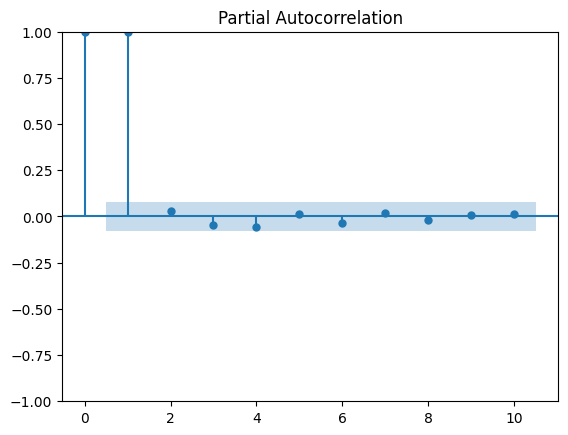

In [9]:
pacf = plot_pacf(sample_table['log_adj_ey_ms'], lags=10)


No gráfico de autocorrelação parcial, podemos ver que apenas um lag do earnings yield ajustado tem correlação com a variável final. 

In [10]:
sample_table[['log_adj_ey_ms', 'log_adj_ey_l1', 'log_adj_ey_l2', 'log_interest']].corr()

,log_adj_ey_ms,log_adj_ey_l1,log_adj_ey_l2,log_interest
log_adj_ey_ms,1.000000,0.049223,0.008128,-0.609177
log_adj_ey_l1,0.049223,1.000000,0.744583,0.003672
log_adj_ey_l2,0.008128,0.744583,1.000000,-0.002794
log_interest,-0.609177,0.003672,-0.002794,1.000000


Além disso, l1 e l2 são extremamente correlatos, ou seja, manter ambos atrapalharia o modelo.

### Treinamento de um modelo

In [11]:
model = smf.ols('log_return ~ log_adj_ey_ms + log_adj_ey_l1 + log_interest', data=sample_table).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_return   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     1181.
Date:                Wed, 25 Sep 2024   Prob (F-statistic):          7.63e-263
Time:                        14:27:41   Log-Likelihood:                 2363.7
No. Observations:                 655   AIC:                            -4719.
Df Residuals:                     651   BIC:                            -4701.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0002      0.001      0.145      0.885      -0.002       0.003
log_adj_ey_ms    -0.0036      0.035     -0.102      0.919      -0.073       0.066
log_adj_ey_l1   -30.8673      0.520    -59.402      0.000     -31.888     -29.847
log_interest     -0.0015      0.025     -0.061      0.952      -0.051       0.048
==============================================================================
Omnibus:                      227.649   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23545.511
Skew:                           0.474   Prob(JB):                         0.00
Kurtosis:                      32.357   Cond. No.                     2.02e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

O único coeficiente significativo parece ser o lag 1 do earnings yield ajustado!

In [12]:
sample_table.dropna(inplace=True)
sample_table['predictions'] = model.predict()
comparison = pd.DataFrame({
    'random_walk': sample_table.log_return,
    'markov_chain': sample_table.log_return - sample_table.predictions,
}).dropna()

Abaixo, temos a comparação de duas premissas: 
- A Random Walk, que presume que a mehlor previsão do retorno é 0;
- A Cadeia de Markov, que presume que a tendência do retorno é previsível por meio de variáveis ocultas;

In [13]:
plx.histogram(
    data_frame=comparison.melt(),
    x='value',
    color='variable',
    barmode='overlay',
    nbins=512,
    height=720,
    width=1280,
)

/home/pedro/.local/lib/python3.10/site-packages/plotly/express/_core.py:1979: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


Parece que a cadeia de Markov teve um desempenho melhor!

## Avaliação do modelo

Agora, vamos verificar como o modelo se comporta com dados fora de amostra.

In [14]:
from datetime import datetime

### Divisão em treino e teste

In [354]:
company = 'NVDA.US'
split_date = datetime(2020, 6, 1)

company_data = final_table.loc[cik_by_ticker[company]]
company_train = company_data[company_data.index <= split_date].dropna()
company_test = company_data[company_data.index > split_date].dropna()

### Treinamento na base de treino

In [355]:
model = smf.ols('log_return ~ log_adj_ey_l1 + log_adj_ey_ms', data=company_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_return   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     736.2
Date:                Wed, 25 Sep 2024   Prob (F-statistic):          2.06e-150
Time:                        16:23:31   Log-Likelihood:                 1340.1
No. Observations:                 508   AIC:                            -2674.
Df Residuals:                     505   BIC:                            -2662.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0036      0.002      1.829      0.068      -0.000       0.008
log_adj_ey_l1   -27.2244      0.714    -38.113      0.000     -28.628     -25.821
log_adj_ey_ms    -0.0684      0.073     -0.934      0.351      -0.212       0.075
==============================================================================
Omnibus:                      221.041   Durbin-Watson:                   2.319
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3086.057
Skew:                           1.507   Prob(JB):                         0.00
Kurtosis:                      14.692   Cond. No.                         928.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Geração de Previsões

In [356]:
company_test['predictions'] = model.predict(company_test)
company_test['model_error'] = company_test['predictions'] - company_test['log_return']

### Vizualização dos resíduos

In [357]:
plx.histogram(
    data_frame=company_test[['log_return', 'model_error']].melt(),
    x='value',
    color='variable',
    barmode='overlay',
    nbins=128,
    height=720,
    width=1280,
)

/home/pedro/.local/lib/python3.10/site-packages/plotly/express/_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



### R-quadrado do modelo

In [358]:
from sklearn.metrics import r2_score

In [359]:
r2_score(company_test.log_return, company_test.predictions)

0.38222280393329644

In [360]:
qq_data = company_test[['log_return', 'model_error']]
qq_data

,log_return,model_error
date,,
2020-06-02,0.002157,0.001309
2020-06-03,-0.006360,0.006348
2020-06-04,0.000079,0.002535
2020-06-05,0.017344,-0.007710
2020-06-08,-0.012878,0.010254
...,...,...
2024-02-22,0.151868,-0.107819
2024-02-23,0.003543,0.000330
2024-02-26,0.003482,0.000375


### Quantile-Quantile Plot

array([<Axes: title={'center': 'Log of Returns'}, xlabel='Theoretical Quantiles', ylabel='Sample Quantiles'>,
       <Axes: title={'center': 'Model Error'}, xlabel='Theoretical Quantiles', ylabel='Sample Quantiles'>],
      dtype=object)

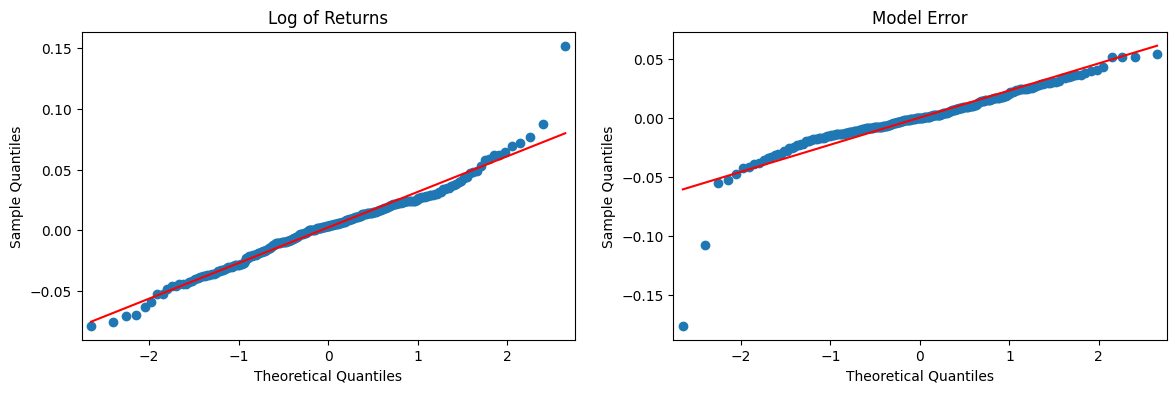

In [361]:

fig, ax = plt.subplots(figsize = (14,4), ncols=2)

sm.qqplot(qq_data['log_return'], line='s',ax = ax[0])
sm.qqplot(qq_data['model_error'], line='s',ax = ax[1])

ax[0].set_title('Log of Returns')
ax[1].set_title('Model Error')

ax

Observe que a distribuição dos erros é parecida com a normal entre -2 e 2 desvios padrão, apenas. Portanto, não podemos presumir a normalidade da distribuição dos erros

### Simulação

In [362]:
np.exp(company_test.model_error.mean())

1.0005306889783228

In [363]:
model_return = ((company_test.predictions > 0).astype(int) * company_test.log_return).cumsum()
buy_hold_return = company_test.log_return.cumsum()
simulation = pd.DataFrame({
    'model_return': model_return,
    'buy_hold_return': buy_hold_return,
})

In [364]:
simulation

,model_return,buy_hold_return
date,,
2020-06-02,0.002157,0.002157
2020-06-03,0.002157,-0.004203
2020-06-04,0.002236,-0.004124
2020-06-05,0.019580,0.013220
2020-06-08,0.019580,0.000341
...,...,...
2024-02-22,2.890634,0.571367
2024-02-23,2.894177,0.574910
2024-02-26,2.897660,0.578392


In [365]:
simulation = np.exp(simulation)

In [367]:
plx.line(
    data_frame=simulation.melt(ignore_index=False).reset_index(),
    x='date',
    y='value',
    color='variable',
    log_y=True
)

/home/pedro/.local/lib/python3.10/site-packages/plotly/express/_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/home/pedro/.local/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



## Conclusão

A métrica proposta, $log(1 + \frac{eps}{price _{i-1}})$ é um bom preditor para o retorno diário de algumas empresas, pelo menos em sua versão diferenciada. Tem progressão aritimética, tal qual $log(price)$, raramente resulta em logarítimos negativos e é baseada numa métrica relativamente fácil de conseguir, o $EPS$. Porém, isso não se aplica a qualquer ativo, sendo necessária uma avaliação prévia. 